#Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
# Constants
BATCH_SIZE = 48
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
AUTOTUNE = tf.data.AUTOTUNE

#Optimised data pipeline

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Git/DL/chest_xray/train",
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Git/DL/chest_xray/test",
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

class_names = train_ds.class_names
print("Class Names:", class_names)

data_augmentation = Sequential([
    Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name='data_augmentation')


Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class Names: ['NORMAL', 'PNEUMONIA']


In [8]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

print("\n tf.data pipeline created.")


 tf.data pipeline created.


#Class weights

In [9]:
DATA_FRACTION = 0.5
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
train_subset_size = int(DATA_FRACTION * train_ds_size)

# Create a subset of the training data
train_ds_subset = train_ds.take(train_subset_size)
print(f"Using {train_subset_size} of {train_ds_size} batches for training ({DATA_FRACTION:.0%}).")

print("\nCalculating class weights on a sample...")
labels_sample = train_ds.unbatch().map(lambda img, label: label).take(1500)
labels_sample_np = np.array([label.numpy() for label in labels_sample])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(np.argmax(labels_sample_np, axis=1)),
    y=np.argmax(labels_sample_np, axis=1)
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Using 54 of 109 batches for training (50%).

Calculating class weights on a sample...
Class Weights: {0: np.float64(1.8427518427518428), 1: np.float64(0.6861848124428179)}


#Model training

In [10]:
def build_and_train_model(base_model_class, model_name, train_data, test_data, class_weights_dict, epochs_to_run, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)):
    print(f"\n--- Building and Training {model_name} ---")

    # Load the base model with pre-trained ImageNet weights, freezing its layers
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(2, activation='softmax', dtype='float32')
    ], name=model_name)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

    history = model.fit(
        train_data,
        epochs=epochs_to_run,
        validation_data=test_data,
        callbacks=[early_stopping],
        class_weight=class_weights_dict
    )

    _, val_accuracy = model.evaluate(test_data, verbose=0)
    print(f'Validation Accuracy ({model_name}): {val_accuracy:.4f}')

    return model, history, val_accuracy


In [18]:
models_to_train = {
    "VGG16": VGG16,
    "MobileNetV2": MobileNetV2,
    "DenseNet121": DenseNet121,
    "InceptionV3": InceptionV3,
    "ResNet50": ResNet50
}

trained_models = {}
model_histories = {}

model_accuracies = {}
for name, model_class in models_to_train.items():
    model, history, val_acc = build_and_train_model(
        model_class, name, train_ds_subset, test_ds, class_weights, epochs_to_run=5
    )
    trained_models[name] = model
    model_histories[name] = history
    model_accuracies[name] = val_acc
    print(f"\n--- Finished initial training for {name} ---\n")


--- Building and Training VGG16 ---
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 502ms/step - accuracy: 0.5945 - loss: 0.8959 - val_accuracy: 0.8173 - val_loss: 0.5766
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.8677 - loss: 0.4539 - val_accuracy: 0.8365 - val_loss: 0.4875
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 678ms/step - accuracy: 0.8911 - loss: 0.3565 - val_accuracy: 0.8381 - val_loss: 0.4595
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 677ms/step - accuracy: 0.8947 - loss: 0.3336 - val_accuracy: 0.8542 - val_loss: 0.4106
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.9139 - loss: 0.2938 - val_accuracy: 0.8478 - val_loss: 0.4344
Restoring model weights from the end of the best epoch: 4.
Validation Accuracy (VGG16): 0.8542

--- Finished initial training for VGG16 ---


--- Building and Training MobileNetV2 ---
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 662ms/step - accuracy: 0.7384 - loss: 0.8017 - val_accuracy: 0.7933 - val_loss: 0.7385
Epoch 2/5
5

#Model performance comparison

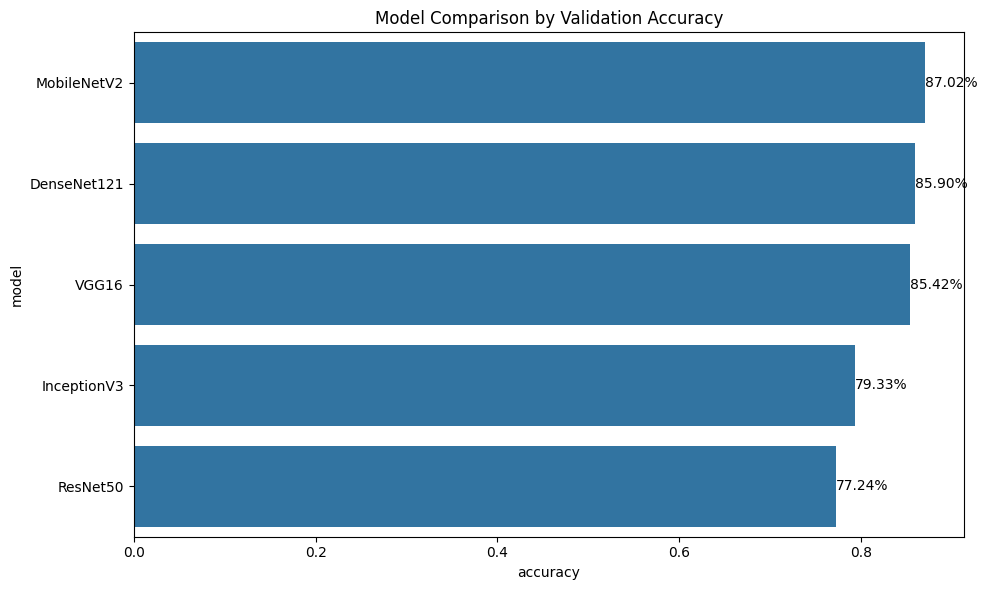

In [19]:
# --- 6. MODEL COMPARISON ---
df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'}).sort_values('accuracy', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='accuracy', y='model', data=df)
ax.bar_label(ax.containers[0], label_type='edge', labels=[f"{x:.2%}" for x in df['accuracy']], fontsize=10)
plt.title('Model Comparison by Validation Accuracy')
plt.tight_layout()
plt.show()

#Fine-tuning the best model

In [20]:
best_model_name = df.iloc[0]['model']
print(f"Best performing model is {best_model_name}")

Best performing model is MobileNetV2


In [22]:
best_model = trained_models[best_model_name]
initial_history = model_histories[best_model_name]

# Unfreeze the base model layers for fine-tuning
base_model = best_model.layers[0]
base_model.trainable = True

# We'll freeze the first half of the layers and fine-tune the rest
num_layers_to_freeze = len(base_model.layers) // 2
print(f"Freezing the first {num_layers_to_freeze} layers of {best_model_name}.")

for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Re-compile the model with a very low learning rate to avoid destroying learned features
low_learning_rate = 1e-5
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=low_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel summary after unfreezing layers for fine-tuning:")
best_model.summary()

fine_tune_epochs = 10
total_epochs = 5 + fine_tune_epochs

history_fine_tune = best_model.fit(
    train_ds,  # Using the full training dataset now
    epochs=total_epochs,
    initial_epoch=initial_history.epoch[-1] + 1,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, verbose=1)
    ]
)

Freezing the first 77 layers of MobileNetV2.

Model summary after unfreezing layers for fine-tuning:


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 2,235,842 (8.53 MB)

 Non-trainable params: 194,496 (759.75 KB)

Epoch 6/15
 54/109 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.8647 - loss: 0.6333

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 109s 344ms/step - accuracy: 0.8753 - loss: 0.5715 - val_accuracy: 0.8109 - val_loss: 0.8749 - learning_rate: 1.0000e-05
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 313ms/step - accuracy: 0.9068 - loss: 0.3639 - val_accuracy: 0.7676 - val_loss: 1.0462 - learning_rate: 1.0000e-05
Epoch 8/15
 54/109 ━━━━━━━━━━━━━━━━━━━━ 26s 490ms/step - accuracy: 0.9179 - loss: 0.3357
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 245ms/step - accuracy: 0.9161 - loss: 0.3409 - val_accuracy: 0.7484 - val_loss: 1.2371 - learning_rate: 1.0000e-05
Epoch 9/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - accuracy: 0.9337 - loss: 0.3167 - val_accuracy: 0.7516 - val_loss: 1.1600 - learning_rate: 2.0000e-06
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


#Final model evaluation

In [24]:
val_loss_finetune, val_accuracy_finetune = best_model.evaluate(test_ds)
print(f'Fine-Tuned Validation Loss: {val_loss_finetune:.4f}')
print(f'Fine-Tuned Validation Accuracy: {val_accuracy_finetune:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6704 - loss: 1.4024
Fine-Tuned Validation Loss: 0.8749
Fine-Tuned Validation Accuracy: 0.8109
